In [34]:
# Pasting these here for easier access

import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count
import os
import sys
import time
import datetime 
from math import *

# 04/22/2025

# Continuing the examination of the PKPD curves of different weight groups to figure out where the bug is

<br>

---

<br>

# Objective 1: Creating PKPD curves for weight groups > 15, > 25, > 35 and <= 35
<br>

---
    
# Using previously calibrated --pmax_artemether 0.9999994 and --ec50_lum 64 values

--- 

### Function call to examine state values of one weight group

In [23]:
# Function to run a single simulation for a given weight value

def run_single_weight_simulation(weight):
    start_time = time.monotonic()
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "5000",
        "--pmax_artemether", "0.9999994",
        "--ec50_lum", "64",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split() for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        
        end_time = time.monotonic()
        today = datetime.date.today()
        print("\nToday's date: ", today, "\n")
        print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

        return efficacy, df_weight, failed_treatment_count
        
    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

### Weight: 10 Kg

In [27]:
# Define the weight values to use
#weight_values = [10, 15, 20, 30, 40]

weight_values = [10]

for weight in weight_values:
        
        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg.csv", index=False)
        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")



Today's date:  2025-04-22 

Length of simulation:  0:02:05.125844 


The failed treatment count for weight 10kg is: 4060

The percentage efficacy for weight 10kg is: 18.799999999999997 



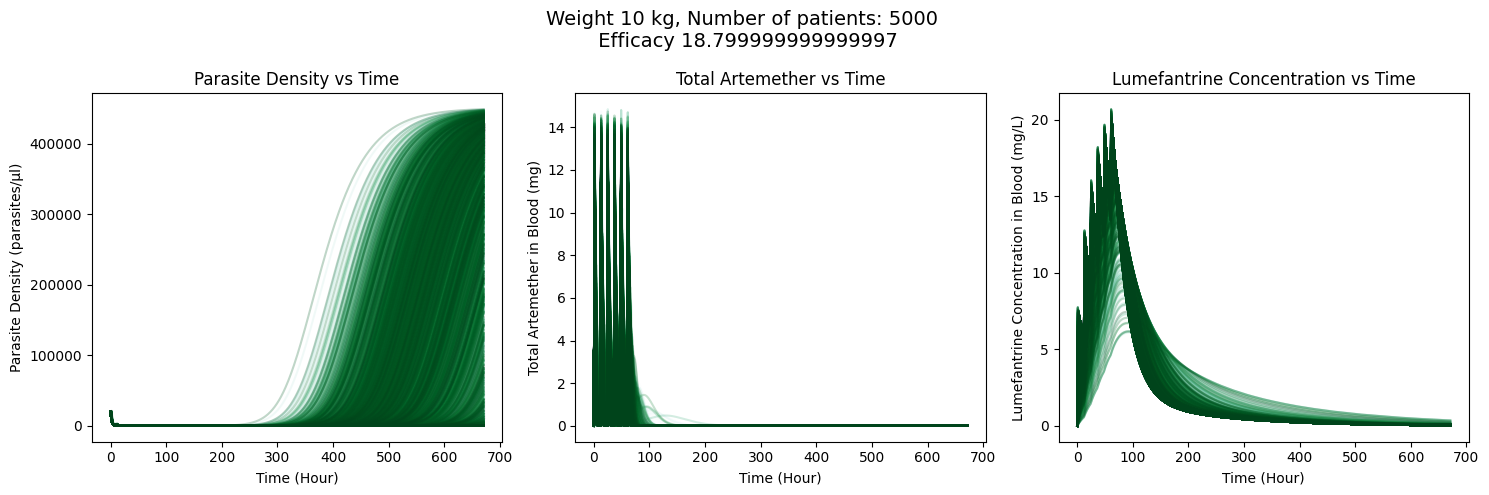

In [ ]:
#Plot parasite density, artemisinin and lumefantrine concentration for weight group 2, run 2, patient weight = 8kg

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

plt.subplot(1, 3, 1)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['PARASITEDENSITY'], color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasites/μl)')
plt.title('Parasite Density vs Time')

plt.subplot(1, 3, 2)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_ART'], color='red')
plt.xlabel('Time (Hour)')
plt.ylabel('Total Artemether in Blood (mg)')
plt.title('Total Artemether vs Time')

plt.subplot(1, 3, 3)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_LUM'], color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration in Blood (mg/L)')
plt.title('Lumefantrine Concentration vs Time')

# Add title for the entire figure
plt.suptitle(f"Weight {weight} kg, Number of patients: {num_pids} \n Efficacy: {floor(efficacy)}%", fontsize=14)
plt.tight_layout()
plt.savefig(f"df_weight_{weight}kg.png")
plt.show()


<br>

### Weight: 20 Kg

In [33]:
weight_values = [20]

for weight in weight_values:
        
        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg.csv", index=False)
        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")



Today's date:  2025-04-22 

Length of simulation:  0:02:12.525941 


The failed treatment count for weight 20kg is: 2117

The percentage efficacy for weight 20kg is: 57.66 



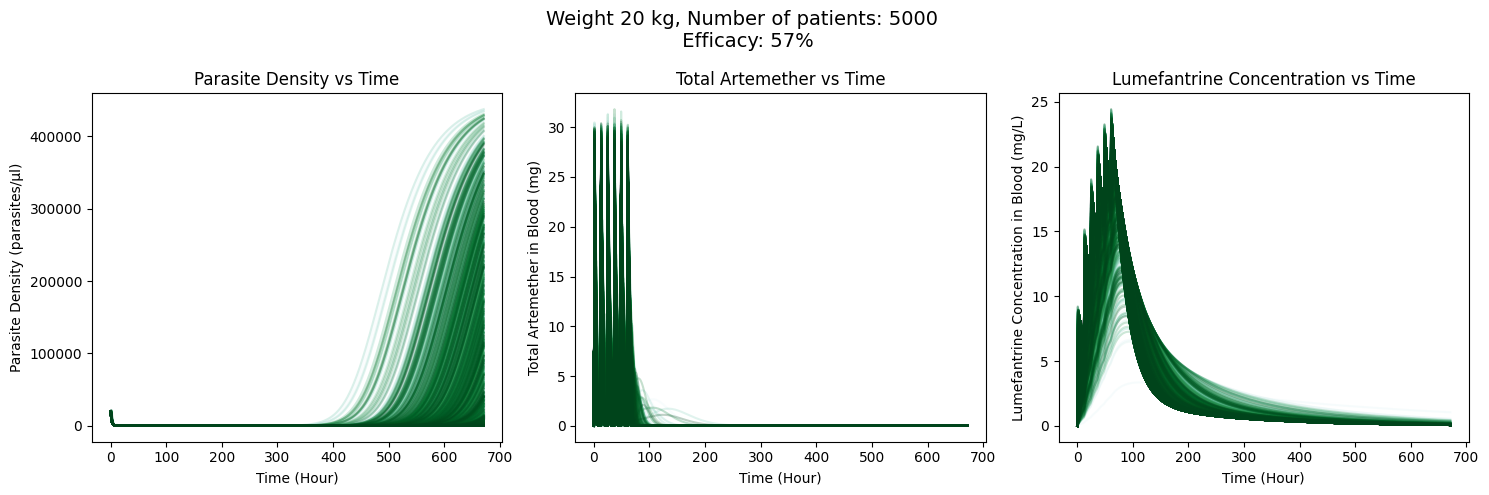

In [37]:
#Plot parasite density, artemisinin and lumefantrine concentration for weight group 2, run 2, patient weight = 8kg

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

plt.subplot(1, 3, 1)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['PARASITEDENSITY'], color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasites/μl)')
plt.title('Parasite Density vs Time')

plt.subplot(1, 3, 2)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_ART'], color='red')
plt.xlabel('Time (Hour)')
plt.ylabel('Total Artemether in Blood (mg)')
plt.title('Total Artemether vs Time')

plt.subplot(1, 3, 3)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_LUM'], color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration in Blood (mg/L)')
plt.title('Lumefantrine Concentration vs Time')

# Add title for the entire figure
plt.suptitle(f"Weight {weight} kg, Number of patients: {num_pids} \n Efficacy: {floor(efficacy)}%", fontsize=14)
plt.tight_layout()
plt.savefig(f"df_weight_{weight}kg.png")
plt.show()


<br>

### Weight: 30 Kg

In [38]:
weight_values = [30]

for weight in weight_values:
        
        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg.csv", index=False)
        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")



Today's date:  2025-04-22 

Length of simulation:  0:02:08.192839 


The failed treatment count for weight 30kg is: 892

The percentage efficacy for weight 30kg is: 82.16 



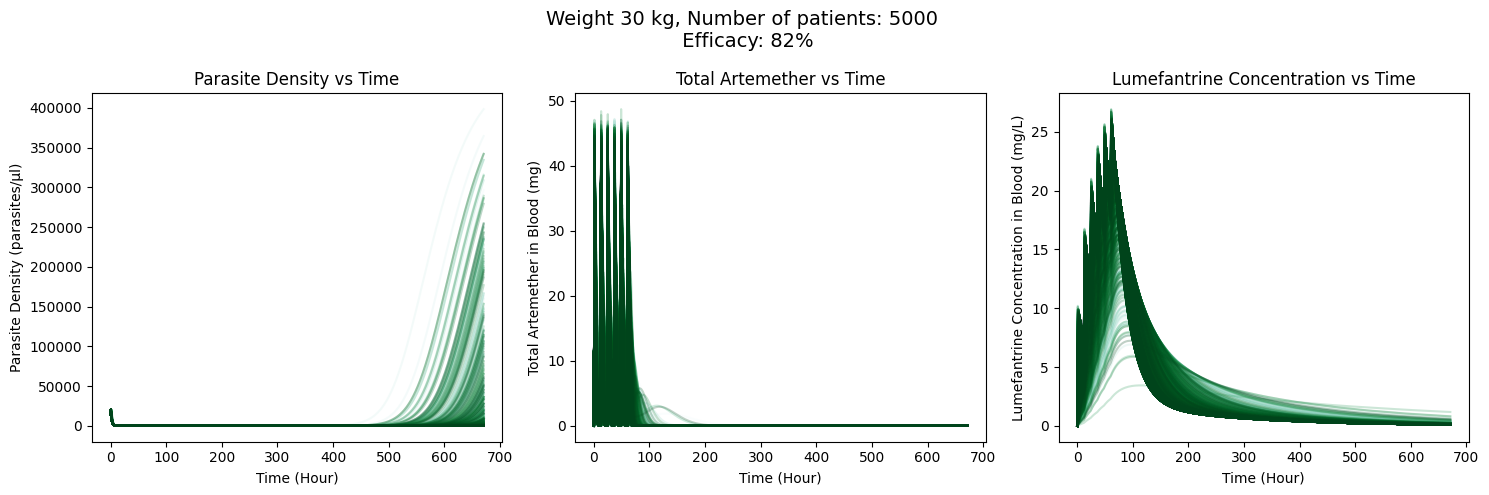

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

plt.subplot(1, 3, 1)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['PARASITEDENSITY'], color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasites/μl)')
plt.title('Parasite Density vs Time')

plt.subplot(1, 3, 2)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_ART'], color='red')
plt.xlabel('Time (Hour)')
plt.ylabel('Total Artemether in Blood (mg)')
plt.title('Total Artemether vs Time')

plt.subplot(1, 3, 3)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_LUM'], color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration in Blood (mg/L)')
plt.title('Lumefantrine Concentration vs Time')

# Add title for the entire figure
plt.suptitle(f"Weight {weight} kg, Number of patients: {num_pids} \n Efficacy: {floor(efficacy)}%", fontsize=14)
plt.tight_layout()
plt.savefig(f"df_weight_{weight}kg.png")
plt.show()


<br>

### Weight: 40 Kg

In [40]:
weight_values = [40]

for weight in weight_values:
        
        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg.csv", index=False)
        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")



Today's date:  2025-04-22 

Length of simulation:  0:02:07.567421 


The failed treatment count for weight 40kg is: 318

The percentage efficacy for weight 40kg is: 93.64 



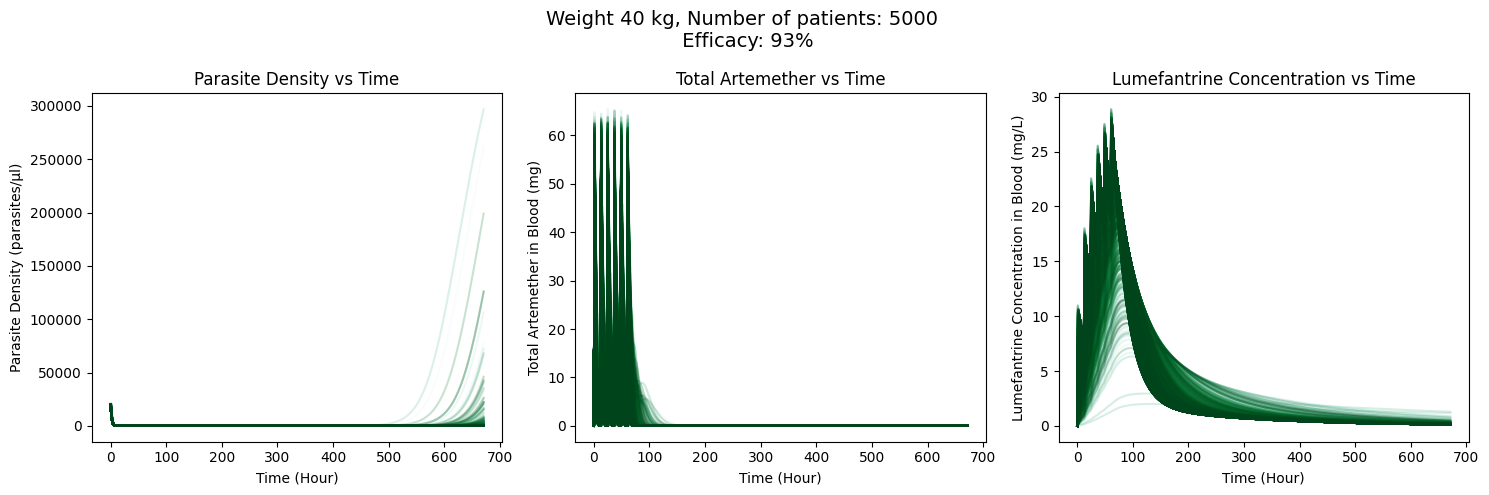

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

plt.subplot(1, 3, 1)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['PARASITEDENSITY'], color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasites/μl)')
plt.title('Parasite Density vs Time')

plt.subplot(1, 3, 2)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_ART'], color='red')
plt.xlabel('Time (Hour)')
plt.ylabel('Total Artemether in Blood (mg)')
plt.title('Total Artemether vs Time')

plt.subplot(1, 3, 3)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_LUM'], color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration in Blood (mg/L)')
plt.title('Lumefantrine Concentration vs Time')

# Add title for the entire figure
plt.suptitle(f"Weight {weight} kg, Number of patients: {num_pids} \n Efficacy: {floor(efficacy)}%", fontsize=14)
plt.tight_layout()
plt.savefig(f"df_weight_{weight}kg.png")
plt.show()